In [1]:
# Carga de contexto y librerias para el notebook :D
%load_ext kedro.ipython
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [2]:
df = catalog.load("Features_training_v2")   # lee el dataset del cat√°logo
list(df.columns)  

[10/25/25 03:36:00] INFO     Loading data from Features_training_v2 (ParquetDataset)...        ]8;id=381368;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=413160;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

['Monetary', 'TimeSinceLastTxn', 'IsLateNight', 'AmountZScoreByLocation', 'IsWeekend']

In [3]:
# =========================================================
# ‚öôÔ∏è XGBOOST REGRESSOR ‚Äì Predicci√≥n de MONETARY
# =========================================================
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================================================
# 1Ô∏è‚É£ Variables dependiente e independientes
# =========================================================
X = df[["AmountZScoreByLocation", "TimeSinceLastTxn", "IsLateNight", "IsWeekend"]]
y = df["Monetary"]

# =========================================================
# 2Ô∏è‚É£ Divisi√≥n Train/Test
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================================================
# 3Ô∏è‚É£ Modelo + Cross Validation
# =========================================================
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(xgb, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = np.sqrt(-cross_val_score(xgb, X_train, y_train, cv=cv, scoring="neg_mean_squared_error"))

print("=== Cross Validation Results (5-Fold) ===")
print("R¬≤ promedio:", round(cv_r2.mean(), 4))
print("R¬≤ desviaci√≥n:", round(cv_r2.std(), 4))
print("RMSE promedio:", round(cv_rmse.mean(), 2))

# =========================================================
# 4Ô∏è‚É£ Entrenamiento y evaluaci√≥n final
# =========================================================
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

results_xgb = {
    "model_name": "XGBRegressor",
    "r2_mean_cv": round(cv_r2.mean(), 4),
    "r2_std_cv": round(cv_r2.std(), 4),
    "r2_test": round(r2, 4),
    "rmse": round(rmse, 2),
    "mae": round(mae, 2)
}

print("\n=== Resultados en Test ===")
print(results_xgb)

# =========================================================
# 5Ô∏è‚É£ Importancia de variables
# =========================================================
importances = pd.DataFrame({
    "Variable": X.columns,
    "Importancia": xgb.feature_importances_.round(4)
}).sort_values("Importancia", ascending=False)

print("\n=== Importancia de las variables ===")
display(importances)

=== Cross Validation Results (5-Fold) ===
R¬≤ promedio: 0.742
R¬≤ desviaci√≥n: 0.002
RMSE promedio: 467.23

=== Resultados en Test ===
{'model_name': 'XGBRegressor', 'r2_mean_cv': np.float64(0.742), 'r2_std_cv': np.float64(0.002), 'r2_test': 0.7436, 'rmse': np.float64(465.67), 'mae': 257.65}

=== Importancia de las variables ===


Variable  Importancia
0  AmountZScoreByLocation       0.8632
1        TimeSinceLastTxn       0.1278
3               IsWeekend       0.0057
2             IsLateNight       0.0032

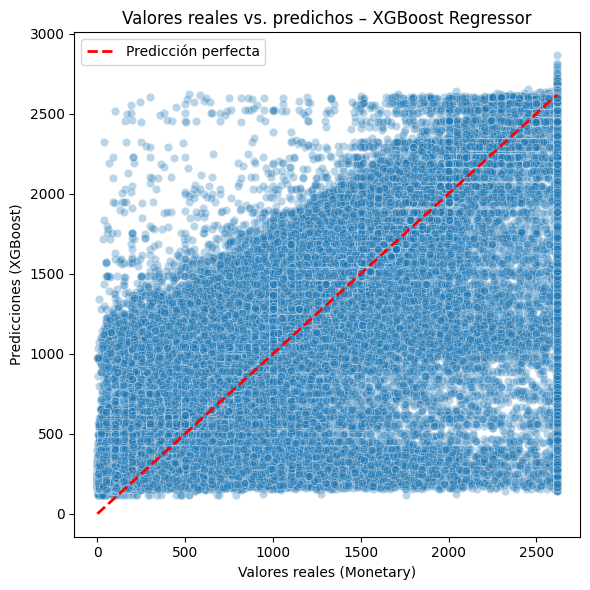

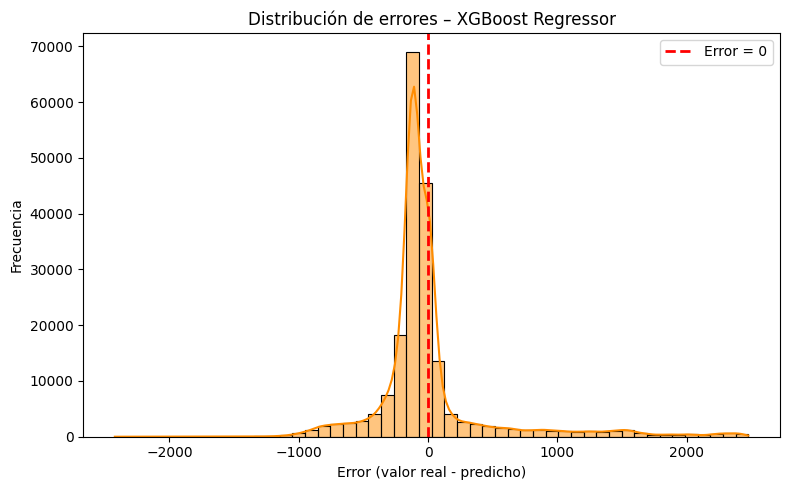

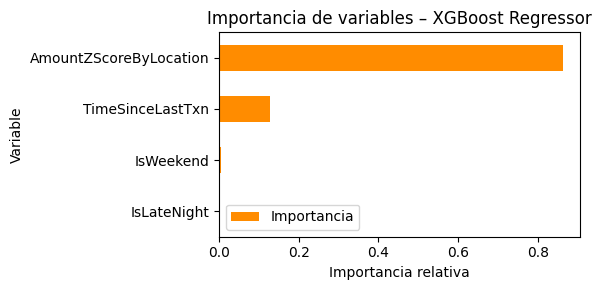

In [4]:

# =========================================================
# 1Ô∏è‚É£ SCATTERPLOT ‚Äì Valores reales vs. predichos
# =========================================================
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', lw=2, label="Predicci√≥n perfecta"
)
plt.xlabel("Valores reales (Monetary)")
plt.ylabel("Predicciones (XGBoost)")
plt.title("Valores reales vs. predichos ‚Äì XGBoost Regressor")
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# 2Ô∏è‚É£ HISTOGRAMA DE ERRORES (Residuos)
# =========================================================
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True, color="darkorange")
plt.axvline(0, color="red", linestyle="--", lw=2, label="Error = 0")
plt.xlabel("Error (valor real - predicho)")
plt.ylabel("Frecuencia")
plt.title("Distribuci√≥n de errores ‚Äì XGBoost Regressor")
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# 3Ô∏è‚É£ IMPORTANCIA DE VARIABLES ‚Äì XGBoost
# =========================================================
importances.sort_values("Importancia", ascending=True).plot(
    kind="barh", x="Variable", y="Importancia", color="darkorange", figsize=(6,3)
)
plt.title("Importancia de variables ‚Äì XGBoost Regressor")
plt.xlabel("Importancia relativa")
plt.tight_layout()
plt.show()

# XGBoost Regressor acaba de superar claramente a todos los modelos anteriores.

# M√©trica	Valor	Comparaci√≥n	Interpretaci√≥n
# R¬≤ promedio (CV)	0.742	üî∫ Mejor que 0.70 (lineales) y 0.69 (RF)	Explica el 74% de la variabilidad del gasto. Excelente.
# R¬≤ Test	0.7436	üîπ Muy estable (sin sobreajuste)	Confirma que el modelo generaliza bien.
# RMSE	465.7	üîΩ Baj√≥ de 505 ‚Üí mejora de ‚âà 8% en error cuadr√°tico medio.	
# MAE	257.6	üîΩ Baj√≥ desde 272 ‚Üí predicciones m√°s precisas en promedio.	

# ‚úÖ Conclusi√≥n:
#  XGBoost no solo mejor√≥ las m√©tricas, sino que mantiene la estabilidad entre CV y Test, lo que lo hace m√°s confiable y robusto.

# El modelo XGBoost Regressor logra el mejor desempe√±o predictivo para estimar el gasto total de un cliente (Monetary), alcanzando un R¬≤ de 0.74 y # # reduciendo el error medio en m√°s de un 10% respecto a los modelos lineales.
# Su capacidad de capturar relaciones no lineales y manejar la importancia de variables permite una predicci√≥n m√°s precisa y estable.